<h1><center>Laboratorio 10: Interpretabilidad 🤖</center></h1>

<center><strong>MDS7202: Laboratorio de Programación Científica para Ciencia de Datos</strong></center>

### Cuerpo Docente:

- Profesor: Pablo Badilla y Ignacio Meza D.
- Auxiliar: Sebastián Tinoco
- Ayudante: Felipe Arias y Diego Cortez

### Equipo: SUPER IMPORTANTE - notebooks sin nombre no serán revisados

- Nombre de alumno 1: Johnny Godoy


### **Link de repositorio de GitHub:** `https://github.com/johnny-godoy/laboratorios-mds/blob/main/2023/lab10/laboratorio_10.ipynb`

### Indice 

1. [Temas a tratar](#Temas-a-tratar:)
3. [Descripcción del laboratorio](#Descripción-del-laboratorio.)
4. [Desarrollo](#Desarrollo)

## Temas a tratar

- Clasificación usando `XGBoost`.
- Métodos Agnósticos Globales de Interpretabilidad (`Partial Dependence Plot`, `Permutation Feature Importance`)
- Métodos Agnósticos Locales de Interpretabilidad (`Scoped Rules`, `SHAP`)

## Reglas:

- **Grupos de 2 personas**
- Asistencia **obligatoria** a instrucciones del lab (viernes 16.15). Luego, pueden quedarse trabajando en las salas o irse.
- **No se revisarán entregas de personas ausentes**. 
- Cualquier duda fuera del horario de clases al foro. Mensajes al equipo docente serán respondidos por este medio.
- Prohibidas las copias. 
- Pueden usar cualquer matrial del curso que estimen conveniente.

### Objetivos principales del laboratorio

- Generar un pipeline de clasificación con `XGBoost`.
- Implementar modelos de interpretabilidad para explicar el funcionamiento del modelo de clasificación.

El laboratorio deberá ser desarrollado sin el uso indiscriminado de iteradores nativos de python (aka "for", "while"). La idea es que aprendan a exprimir al máximo las funciones optimizadas que nos entrega `pandas`, las cuales vale mencionar, son bastante más eficientes que los iteradores nativos sobre DataFrames.

# 1. Problemas Clínicos del Dr. Simi

<p align="center">
  <img src="https://gantz.cl/wp-content/uploads/2020/01/79024136_2718114448239059_7240913062570491904_o.jpg" width="350">
</p>

El reconocido **Dr. Simi**, famoso vendedor de medicamentos en latinoamerica, debido a la creciente prevalencia de enfermedades crónicas, como la diabetes, decidió abrir una clínica especializada en el tratamiento de esta enfermedad en nuestro país.

La clínica del Doctor Simi se convirtió en un lugar donde los pacientes con diabetes podrían recibir atención médica integral. El personal médico estaba compuesto por especialistas en endocrinología, nutrición y enfermería, todos capacitados en el manejo de la diabetes.

Sin embargo él se ha dado cuenta que los tiempos han cambiado y gracias a las tecnologías es posible generar mejores predicciones en la diabetes conociendo el historial médico de las personas. Por esto, el doctor se ha colocado una meta de incluir modelos de machine learning dentro de sus clínicas, para ello le ha solicitado crear un modelo capaz de predecir/clasificar diabetes pero le rogó que el desarrollo del modelo tuviera un especial enfoque en la interpretabilidad de lo que hace su modelo.

Para que usted pueda entrenar el modelo, Dr. Simi le ha entregado un dataset de todos los clientes que fueron detectados con diabetes a lo largo de la historia de la clinica. Con ello, adjunta el historial médico de las personas en forma de datos tabulares para que usted pueda realizar fácilmente la clasificación.


In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

In [2]:
df = pd.read_csv("data/input/diabetes_data.csv")
df.head(4)

,Age,Sex,HighChol,CholCheck,BMI,Smoker,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,GenHlth,MentHlth,PhysHlth,DiffWalk,Stroke,HighBP,Diabetes
0,4.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,5.0,30.0,0.0,0.0,1.0,0.0
1,12.0,1.0,1.0,1.0,26.0,1.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,1.0,0.0
2,13.0,1.0,0.0,1.0,26.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,10.0,0.0,0.0,0.0,0.0
3,11.0,1.0,1.0,1.0,28.0,1.0,0.0,1.0,1.0,1.0,0.0,3.0,0.0,3.0,0.0,0.0,1.0,0.0


## 2. Clasificación de pacientes con diabetes (0.5 pt)

<p align="center">
  <img src="https://media.tenor.com/QH--g3ZaSbsAAAAC/dr-simi-abrazo.gif" width="400">
</p>

En primer lugar, el reconocido doctor le pide entrenar un modelo de `XGBoost` utilizando como target la columna `Diabetes` del dataset `diabetes_data.csv`. Para el entrenamiento tome en cuenta **todos** los pasos necesarios para entrenar un modelo de aprendizaje supervisado vistos hasta la fecha (use `Pipeline`, `ColumnTransformer`, etc.), comente sus decisiones y los resultados obtenidos con el modelo. ¿Es acaso un buen predictor de diabetes?, ¿Qué buscan explicar las métricas utilizadas?, ¿las métricas utilizadas para medir la predictibilidad le permiten asegurar que su modelo una buena elección de las features?.

In [3]:
X = df.drop(columns=["Diabetes"])
y = df["Diabetes"]

In [4]:
def tabla_evaluacion(*args, **kwargs) -> pd.DataFrame:
    """
    Retorna una tabla con los resultados de cross_validate.

    Parametros
    ----------
    *args : list
        Lista de argumentos para cross_validate.
    **kwargs : dict
        Diccionario de argumentos para cross_validate.

    Returns
    -------
    pd.DataFrame
        Tabla con los resultados de cross_validate.

    """
    df_eval = pd.DataFrame(cross_validate(*args, **kwargs))
    concat = pd.concat((df_eval, df_eval.agg(("mean", "std"))), ignore_index=True)
    concat.index = [*range(len(concat) - 2), "mean", "std"]
    return concat

Se busca utilizar un modelo simple de programar, por lo que se utiliza `XGBoost` con
sus parámetros por defecto. Éste modelo está basado en árboles, así que el único
preprocesamiento requerido es codificar las variables categóricas. Para esto
cualquier esquema sirve, pero uno de los más simples y qué da buenos resultados en
modelos de árboles en `OrdinalEncoder`.

También intentaré hacer una validación simple, solamente una validación cruzada
estratificada con 10 _folds_, midiendo el _f1 score_, debido a que es una medida
robusta que balancea la precisión y el _recall_ sin tener que pensar mucho más
profundamente en la decisión. Podremos interpretar esta medida como un error total de
 clasificación. También se medirá el _recall_ y la precisión por separado para tener una
    idea de qué tan bien se comporta el modelo en cada clase.

In [5]:
clf = make_pipeline(
    OrdinalEncoder(
        dtype=np.float32,  # Más eficiente para XGBoost
        handle_unknown="use_encoded_value",  # Evita errores en el test set
        unknown_value=-1,  # Valor no importa, pero debe ser distinto a los demás
    ),
    xgb.XGBClassifier(),
)
clf.set_output(transform="pandas")
df_eval = tabla_evaluacion(
    clf,
    X,
    y,
    return_train_score=True,
    cv=10,
    scoring=("precision", "recall", "f1"),
    n_jobs=-2,
)
df_eval

,fit_time,score_time,test_precision,train_precision,test_recall,train_recall,test_f1,train_f1
0,8.024809,0.054013,0.730994,0.756762,0.777935,0.823206,0.753734,0.788587
1,7.951794,0.056012,0.716180,0.757700,0.763791,0.821320,0.739220,0.788228
2,8.007807,0.054010,0.729569,0.756664,0.800792,0.821860,0.763524,0.787915
3,7.938788,0.056013,0.726343,0.756230,0.784097,0.822268,0.754116,0.787868
4,8.013807,0.059013,0.726990,0.757880,0.793435,0.821608,0.758761,0.788458
5,8.047815,0.057012,0.733914,0.756585,0.787493,0.820728,0.759760,0.787352
6,7.950792,0.056014,0.736347,0.756862,0.797171,0.820031,0.765553,0.787181
7,7.928788,0.053013,0.722710,0.754206,0.814710,0.820188,0.765957,0.785814
8,8.003805,0.054012,0.729545,0.757532,0.784441,0.823614,0.755998,0.789192
9,8.022805,0.056015,0.734419,0.757254,0.803395,0.817076,0.767360,0.786029


* Todos los puntajes son estables en cada _fold_, lo que indica que el modelo no está
    sobreajustando a cada _fold_.
* Tanto precisión como _recall_ se mantiene en rangos similares y altos, lo que indica
    que el modelo no está sesgado hacia una clase.
* En general, el modelo tieen un _f1 score_ de 0.75 en el conjunto de prueba,
mostrando un buen desempeño de clasificación. Su puntaje en el conjunto de
entrenamiento es de 0.79, un poco mayor, pero no suficiente para determinar sobreajuste.

Con esto, respondemos las preguntas:

* ¿Es acaso un buen predictor de diabetes? R: Muestra un buen puntaje de
clasificación al realizar validación cruzada, pero ésto es solamente un proxy del
error de generalización verdadero. En realidad, no sabemos si los datos
proporcionados son suficientemente representativos de la población de pacientes, y no
 se realizó un EDA para validar que éstos datos permitan una capacidad de generalizar
  para pacientes reales.
* ¿Qué buscan explicar las métricas utilizadas? R: Que el modelo sea capaz de
 clasificar correctamente a los pacientes fuera de la muestra de entrenamiento (pero
 dentro del conjunto de prueba).
* ¿Las métricas utilizadas para medir la predictibilidad le permiten asegurar que su
modelo una buena elección de las features? R: No, solamente determinan que el modelo
es preciso, pero `XGBoost` no realiza una selección de características, y puede
ajustarse al ruido específico de este conjunto de datos. Debido a que utiliza mecanismos como _column subsampling_, el modelo
puede terminar utilizando características inútiles, y estará sesgado hacia utilizar
más frecuentemente características repetidas.

## 3. Importancia de las features con XGBoost (0.5 pt)

<p align="center">
  <img src="https://media.tenor.com/5JAj5_IiagEAAAAd/dr-simi-dr-simi-dance.gif" width="400">
</p>

Para añadir el toque de interpretabilidad que Dr. Simi le pide, se le pide calcular la importancia de las features del modelo entrenado utilizando todos los métodos (weight, cover, gain) que posee xgboost usando plot_importance. ¿Los resultados obtenidos con los diferentes métodos son compatibles?, comente sus resultados y a que se debe la igualdad o desigualdad que ve en los resultados. Finalmente, ¿las importancias obtenidas son suficientes para obtener la interpretabilidad de un modelo que utiliza árboles? ¿Qué debilidad presenta este método?

In [6]:
clf.fit(X, y);

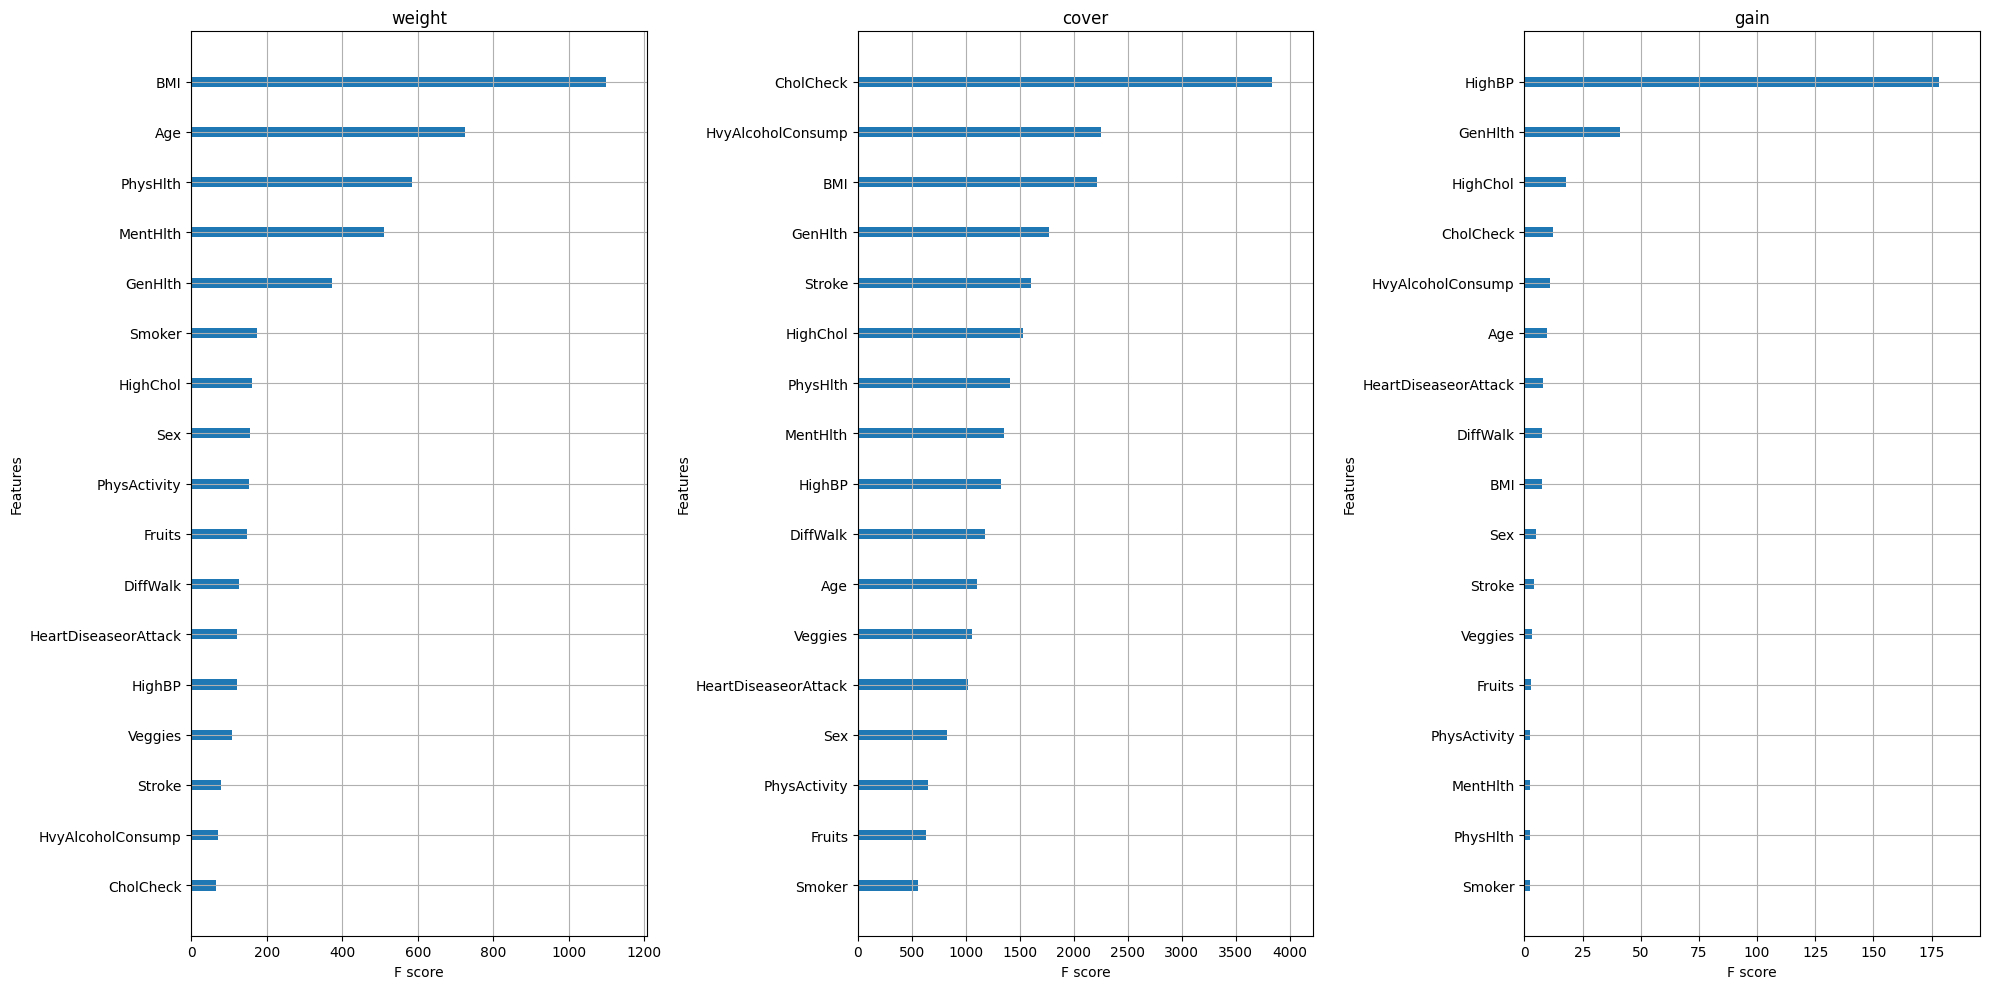

In [10]:
fig, axes = plt.subplots(ncols=3, figsize=(20, 10))
importance_types = ("weight", "cover", "gain")
for method, ax in zip(importance_types, axes):
    xgb.plot_importance(
        clf[1], importance_type=method, title=method, ax=ax, show_values=False
    )
plt.tight_layout()

In [8]:
def sort_by_importance(importance_type: str) -> pd.DataFrame:
    """
    Sorts features by importance.

    Parameters
    ----------
    importance_type : str
        Importance type to sort by.

    Returns
    -------
    pd.DataFrame
        Sorted features.
    """
    scores = clf[1].get_booster().get_score(importance_type=importance_type)
    return pd.Series(scores).sort_values(ascending=False).index.to_list()

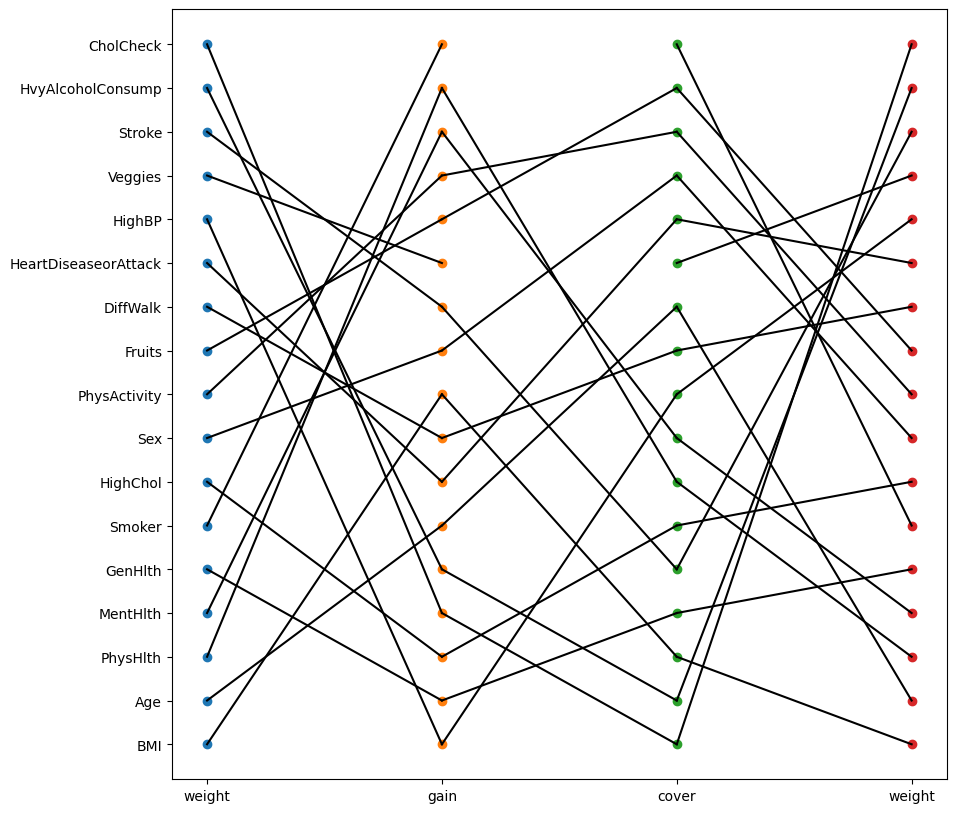

In [59]:
importances = {method: sort_by_importance(method) for method in importance_types}
weight = importances["weight"]
x = np.zeros_like(weight, dtype=np.float32)
y = np.arange(len(weight))
fig, ax = plt.subplots(figsize=(10, 10))
for i, method in enumerate(importance_types):
    ax.scatter(x + i, y, marker="o", label=method)
ax.scatter(x + i + 1, y, marker="o", label="A")

for i, a in enumerate(weight):
    for j, b in enumerate(importances["gain"]):
        if a == b and i != j:
            ax.plot([0, 1], [i, j], color="k")

for i, a in enumerate(importances["gain"]):
    for j, b in enumerate(importances["cover"]):
        if a == b and i != j:
            ax.plot([1, 2], [i, j], color="k")

for i, a in enumerate(importances["cover"]):
    for j, b in enumerate(weight):
        if a == b and i != j:
            ax.plot([2, 3], [i, j], color="k")

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ax.set_yticklabels(weight)
    ax.set_yticks(y)
    ax.set_xticklabels(["weight", "gain", "cover", "weight"])
    ax.set_xticks([0, 1, 2, 3])

## 4. Métodos Agnósticos Globales (1 pt)

<p align="center">
  <img src="https://media.tenor.com/JcRHtjVuXN8AAAAC/dr-simi-farmacias-similares.gif" width="400">
</p>

Para mitigar los problemas encontrados en la sección anterior, Dr. Simi le pide implementar un **método de permutación** que le permita observar la importancia de las features. Visualice los resultados de este método en un gráfico. Para que su modelo sea consistente, repita el proceso **30 veces** y verifique la desviación estándar de sus resultados (¿Qué señala está?). Además, responda las siguientes preguntas:


- ¿Cómo mide la importancia de las features su propuesta?
- ¿Qué features tienen un mayor impacto en la salida del modelo?. Comente las 5 primeras, ¿Tienen sentido?
- ¿Cómo cambian sus conclusiones con respecto a las features importances del punto anterior?
- Nombre y explique 3 ventajas y 3 desventajas del método implementado.

In [ ]:
# Inserte su código aquí

## 5. Métodos Agnósticos Locales (2 pt)

<p align="center">
  <img src="https://i.makeagif.com/media/1-27-2017/fBrzT8.mp4" width="400">
</p>

### Parte A (0.4 pt)

Alegre por saber cómo funciona el modelo de predicción a nivel general, Dr. Simi le pide ahora interpretar las predicciones de su modelo a nivel de paciente (es decir, desde un punto de vista **local**). Para esto, el ilustre farmacéutico le pide calcular los *shap values* de su modelo. ¿Qué representa cada número en su resultado? ¿Es posible atribuir un significado a la positividad/negatividad de cada valor?

In [ ]:
warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")

In [ ]:
# Inserte código para calcular shapley values aquí

### Parte B (0.4 pt)

Usando los *shap values* calculados, grafique el **aporte** de las diferentes variables para las instancias **1**, **9** y **150**, interprete sus resultados y responda:
- ¿Qué variables afectan de manera positiva/negativa a la probabilidad de poseer diabetes? 
- ¿Existe algún patrón común entre las instancias analizadas? 
- ¿Es posible generalizar estas conclusiones a todo el dataset?

In [ ]:
# Inserte código para generar gráficos de aporte local aquí

### Parte C (0.4 pt)

Genere ahora una visualización donde se grafique el aporte de cada feature a nivel **global** e interprete sus resultados. ¿Qué diferencias existen con las conclusiones generadas a nivel de instancia?

In [ ]:
# Inserte código para generar gráficos de aporte global aquí

### Parte D (0.4 pt)

Grafique ahora un *scatterplot* entre los *shap values* y las primeras 5 features con mayor impacto global (un gráfico por cada feature), coloreando cada punto por la probabilidad de tener diabetes. ¿Qué puede concluir de sus resultados?

In [ ]:
# Inserte código para generar gráficos de feature vs shap value aquí

### Parte E (0.4 pt)

Finalmente, se le pide generar un gráfico del tipo **Partial Dependence Plot** para las mismas 5 variables con mayor impacto global usando una submuestra de **1000 observaciones**. ¿Qué relación existe entre la salida promedio del modelo y cada feature analizada? ¿Son estas conclusiones generalizables para todo el conjunto de datos?

In [ ]:
# Inserte código para generar gráficos PDP aquí

## 6. Sistema de Reglas! (1 pt)

<p align="center">
  <img src="https://media.baamboozle.com/uploads/images/125978/1638281150_1380186_gif-url.gif" width="400">
</p>

Después de todo el trabajo hecho, Dr. Simi le pide simplificar el funcionamiento de su modelo en un sistema de reglas que le permita explicar a sus clientes las predicciones que genera su modelo. En particular, Dr. Simi le pide explicar la decisión tomada para las observaciones **1000**, **3001** y **5751**. Con las reglas propuestas señale a **cuánta población** es posible explicar con estas reglas e indique la **precisión** que poseen las reglas en la totalidad de los datos. ¿Tienen sentido sus reglas propuestas para las observaciones?. Fundamente sus respuesta señalando el impacto que tienen sus reglas sobre todo el conjunto de datos.

In [ ]:
# Inserte su código para generar sistema de reglas aquí

idx = 1000
# explicar predicción idx 1000

idx = 3001
# explicar predicción idx 3001

idx = 5751
# explicar predicción idx 5751

# Retrospectiva... (1 pt)

En base a los diferentes métodos que implementa y ha comentado en este laboratorio, comente qué métodos le permiten entregar mejores conclusiones para la tarea de clasificación de diabetes. Por otro lado, ¿qué métodos son más útiles para el problema del doctor Simi, métodos agnosticos locales o globales?

> Fundamente su Respuesta aquí

# Conclusión
Eso ha sido todo para el lab de hoy, recuerden que el laboratorio tiene un plazo de entrega de una semana. Cualquier duda del laboratorio, no duden en contactarnos por mail o U-cursos.

![Gracias Totales!](https://media.tenor.com/ctnq4bhZE3gAAAAC/drsimi-simi.gif)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87110296-876e-426f-b91d-aaf681223468' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>